In [1]:
!pip install seaborn
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl (375.9 MB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json # For loading the JSON file

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score
)

In [3]:
# PySwarms
import pyswarms as ps

In [4]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries imported and seeds set.")
print(f"TensorFlow version: {tf.__version__}")
print(f"PySwarms version: {ps.__version__}")

Libraries imported and seeds set.
TensorFlow version: 2.19.0
PySwarms version: 1.3.0


In [5]:
# File path definition
json_file_path = 'yugioh_monster_cards.json'

In [7]:
# Load the JSON data
try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df_raw = pd.DataFrame(data)
    print(f"Successfully loaded {json_file_path}")
    print(f"Dataset shape: {df_raw.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at {json_file_path}. Please check the path.")
except Exception as e:
    print(f"ERROR: An error occurred while loading the JSON file: {e}")

Successfully loaded yugioh_monster_cards.json
Dataset shape: (8500, 7)


In [8]:
# Initial Inspection
if 'df_raw' in locals():
    print("\n--- 1. Initial Inspection ---")
    print("\nData Info:")
    df_raw.info()

    print("\nFirst 5 rows:")
    print(df_raw.head())

    print("\nDescriptive Statistics (Numerical):")
    print(df_raw.describe(include='all'))

    print("\nValue counts for 'Attribute' (our target variable):")
    if 'Attribute' in df_raw.columns:
        print(df_raw['Attribute'].value_counts())
    else:
        print("'Attribute' column not found.")

    print("\nValue counts for 'Level':")
    if 'Level' in df_raw.columns:
        print(df_raw['Level'].value_counts().sort_index().head(10)) 
    else:
        print("'Level' column not found.")

    print("\nValue counts for 'Type' (sample):")
    if 'Type' in df_raw.columns:
        print(df_raw['Type'].value_counts().head(10))
    else:
        print("'Type' column not found.")


--- 1. Initial Inspection ---

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         8500 non-null   object
 1   Attribute    8500 non-null   object
 2   Level        8500 non-null   int64 
 3   Type         8500 non-null   object
 4   ATK          8500 non-null   int64 
 5   DEF          8500 non-null   int64 
 6   Description  8500 non-null   object
dtypes: int64(3), object(4)
memory usage: 465.0+ KB

First 5 rows:
                               Name Attribute  Level                Type  \
0                    3-Hump Lacooda     EARTH      3        Beast/Effect   
1         4-Starred Ladybug of Doom      WIND      3  Insect/Flip/Effect   
2                    7 Colored Fish     WATER      4         Fish/Normal   
3                  8-Claws Scorpion      DARK      2       Insect/Effect   
4  A Bao A Qu, the Lightless Shadow

In [9]:
# Feature Engineering: Extract Primary_Type
if 'df_raw' in locals() and 'Type' in df_raw.columns:
    df_processed = df_raw.copy()
    # Handle potential errors if a 'Type' string doesn't contain '/'
    df_processed['Primary_Type'] = df_processed['Type'].apply(lambda x: x.split('/')[0] if isinstance(x, str) and '/' in x else x)
    print("\n'Primary_Type' created. Sample value counts:")
    print(df_processed['Primary_Type'].value_counts().head())
else:
    print("Skipping Primary_Type creation as df_raw or Type column is missing.")
    # Potentially re-assign df_processed if it wasn't created
    if 'df_raw' in locals():
        df_processed = df_raw.copy()


'Primary_Type' created. Sample value counts:
Primary_Type
Warrior        1062
Machine         981
Fiend           823
Dragon          738
Spellcaster     711
Name: count, dtype: int64


In [ ]:
# Define Features (X) and Target (y)
if 'df_processed' in locals() and 'Attribute' in df_processed.columns:
    # Drop 'Name', 'Description', and original 'Type' column
    # 'Level', 'ATK', 'DEF' are numerical. 'Primary_Type' is categorical.
    features_to_drop = ['Name', 'Description', 'Type']
    X = df_processed.drop(columns=['Attribute'] + features_to_drop, errors='ignore')
    y = df_processed['Attribute']

    print("\n--- 2. Feature Selection ---")
    print("Features (X) columns:", X.columns.tolist())
    print("Target (y) name:", y.name)

    # Identify Numerical and Categorical Features
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist() # 'Primary_Type'

    print(f"\nNumerical features: {numerical_features}")
    print(f"Categorical features: {categorical_features}")

    # Preprocessing Pipelines
    # Numerical features: StandardScaler
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Categorical features: OneHotEncoder
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
    ])

    # Create preprocessor
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ], remainder='passthrough') # passthrough for any columns not specified

    # Apply Preprocessing to X
    X_processed = preprocessor.fit_transform(X)
    print(f"\nShape of X_processed (after one-hot encoding, etc.): {X_processed.shape}")

    # Try to get feature names after OHE 
    try:
        ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
        all_feature_names = numerical_features + list(ohe_feature_names)
        print(f"Number of features after OHE: {len(all_feature_names)}")
        print(f"Sample feature names (first 10): {all_feature_names[:10]}...")
    except Exception as e:
        print(f"Could not get OHE feature names: {e}")
        all_feature_names = None # Fallback

    #  Label Encode the Target Variable (y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    print(f"\nTarget variable '{y.name}' encoded.")
    print(f"Number of unique classes: {num_classes}")
    print(f"Class mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
    target_class_names = label_encoder.classes_ 

    # Train-Test Split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_processed, y_encoded,
        test_size=0.2,
        random_state=SEED,
        stratify=y_encoded 
    )

    print("\n--- 3. Train Test Split ---")
    print(f"X_train_full shape: {X_train_full.shape}, y_train_full shape: {y_train_full.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Check class distribution in splits (optional but good practice)
    print("\nTraining set class distribution (encoded):")
    print(pd.Series(y_train_full).value_counts(normalize=True).sort_index())
    print("\nTest set class distribution (encoded):")
    print(pd.Series(y_test).value_counts(normalize=True).sort_index())

    # Define input_dim for Neural Network
    input_dim = X_train_full.shape[1]
    print(f"\nInput dimension for NN: {input_dim}")

else:
    print("ERROR: df_processed or target column 'Attribute' not found. Cannot proceed with preprocessing.")


--- 2. Feature Selection ---
Features (X) columns: ['Level', 'ATK', 'DEF', 'Primary_Type']
Target (y) name: Attribute

Numerical features: ['Level', 'ATK', 'DEF']
Categorical features: ['Primary_Type']

Shape of X_processed (after one-hot encoding, etc.): (8500, 28)
Number of features after OHE: 28
Sample feature names (first 10): ['Level', 'ATK', 'DEF', 'Primary_Type_Aqua', 'Primary_Type_Beast', 'Primary_Type_Beast-Warrior', 'Primary_Type_Cyberse', 'Primary_Type_Dinosaur', 'Primary_Type_Divine-Beast', 'Primary_Type_Dragon']...

Target variable 'Attribute' encoded.
Number of unique classes: 7
Class mapping: {'DARK': 0, 'DIVINE': 1, 'EARTH': 2, 'FIRE': 3, 'LIGHT': 4, 'WATER': 5, 'WIND': 6}

--- 3. Train Test Split ---
X_train_full shape: (6800, 28), y_train_full shape: (6800,)
X_test shape: (1700, 28), y_test shape: (1700,)

Training set class distribution (encoded):
0    0.280000
1    0.000588
2    0.223824
3    0.090441
4    0.209559
5    0.103088
6    0.092500
Name: proportion, dtyp


--- Phase 2: Building a baseline Neural Network ---

--- 4. Define the Baseline Neural Network Architecture ---

--- 5. Compile the Baseline Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,167 (16.28 KB)

 Trainable params: 4,167 (16.28 KB)

 Non-trainable params: 0 (0.00 B)


--- 6. Train the Baseline Model ---
Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2157 - loss: 1.8714 - val_accuracy: 0.3838 - val_loss: 1.6070
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.3809 - loss: 1.6040 - val_accuracy: 0.4581 - val_loss: 1.4775
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.4540 - loss: 1.4902 - val_accuracy: 0.4743 - val_loss: 1.4086
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.4724 - loss: 1.4298 - val_accuracy: 0.4794 - val_loss: 1.3834
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.4897 - loss: 1.3965 - val_accuracy: 0.4779 - val_loss: 1.3754
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.4870 - loss: 1.3945 - val_accuracy: 0.4809 - val_loss: 1.3651
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.4852 - loss: 1.3793 - val_accuracy: 0.4801 - val_loss: 1.3660
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 852u

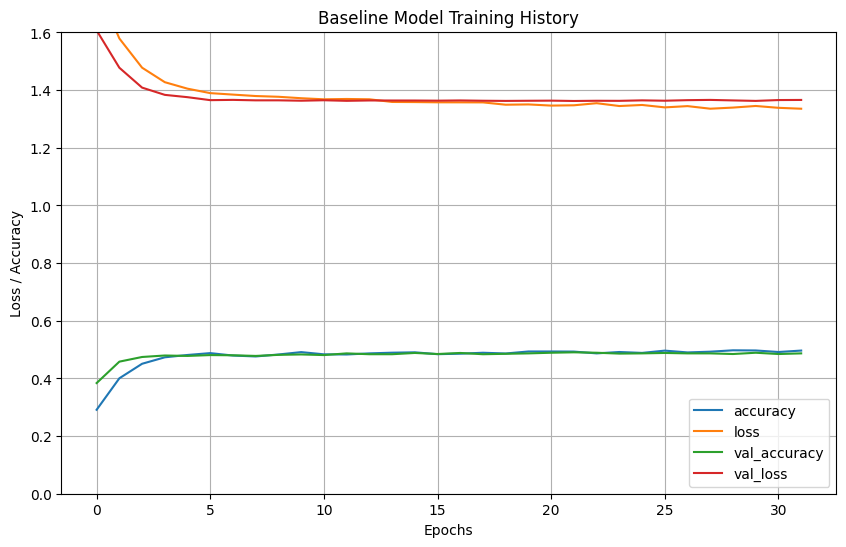


--- 8. Evaluate the Baseline Model on Test Set ---

Baseline Model Test Loss: 1.3700
Baseline Model Test Accuracy: 0.4924
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step

Baseline Model Classification Report:
              precision    recall  f1-score   support

        DARK       0.47      0.65      0.55       476
      DIVINE       0.00      0.00      0.00         1
       EARTH       0.44      0.75      0.56       380
        FIRE       0.88      0.15      0.26       154
       LIGHT       0.48      0.32      0.38       356
       WATER       0.85      0.46      0.59       175
        WIND       0.60      0.17      0.27       158

    accuracy                           0.49      1700
   macro avg       0.53      0.36      0.37      1700
weighted avg       0.55      0.49      0.47      1700

Baseline Matthews Correlation Coefficient (MCC): 0.3529
Baseline Cohen's Kappa: 0.3398
Baseline Balanced Accuracy: 0.3563

Baseline Model Confusion Matrix:


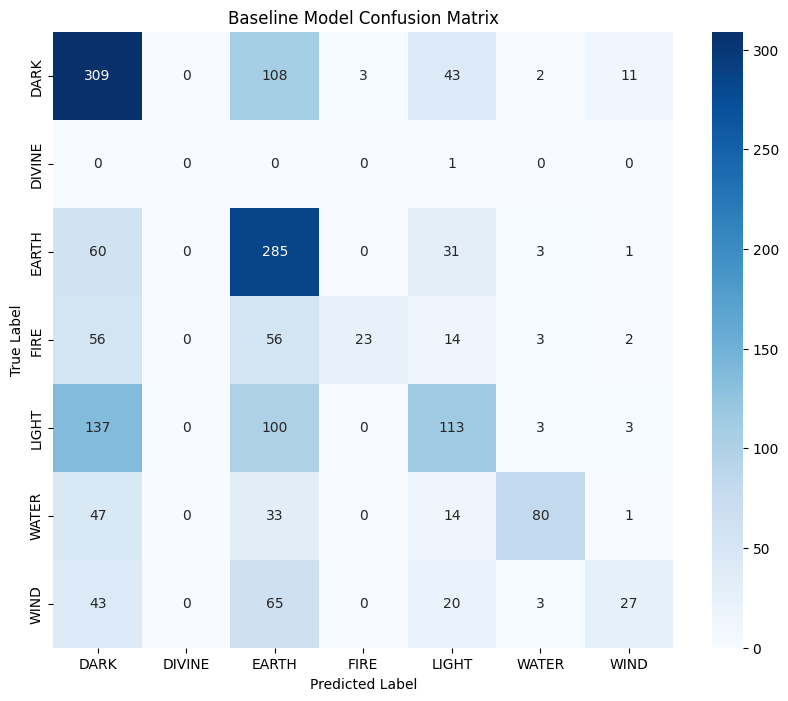

In [12]:
# Define the Baseline Neural Network Architecture
print("\n--- Phase 2: Building a baseline Neural Network ---")
print("\n--- 4. Define the Baseline Neural Network Architecture ---")

baseline_model = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation='relu'), 
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax') 
])

# Compile the Model
print("\n--- 5. Compile the Baseline Model ---")
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

# Train the Model
print("\n--- 6. Train the Baseline Model ---")
# Early stopping to prevent overfitting
baseline_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

baseline_history = baseline_model.fit(
    X_train_full, y_train_full,
    epochs=100, 
    batch_size=32,
    validation_split=0.2,
    callbacks=[baseline_early_stopping],
    verbose=1
)

# Plot Training History
print("\n--- 7. Plot Baseline Model Training History ---")
if baseline_history.history:
    pd.DataFrame(baseline_history.history).plot(figsize=(10, 6))
    plt.title("Baseline Model Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    min_loss = min(baseline_history.history.get('loss', [1]))
    max_acc = max(baseline_history.history.get('accuracy', [0]))
    plt.ylim(0, max(1.0, max_acc * 1.2, min_loss * 1.2)) 
    plt.grid(True)
    plt.show()
else:
    print("No training history to plot for baseline model.")


# Evaluate the Baseline Model on the Test Set
print("\n--- 8. Evaluate the Baseline Model on Test Set ---")
loss_baseline, accuracy_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"\nBaseline Model Test Loss: {loss_baseline:.4f}")
print(f"Baseline Model Test Accuracy: {accuracy_baseline:.4f}")

# Get predictions
y_pred_probs_baseline = baseline_model.predict(X_test)
y_pred_baseline = np.argmax(y_pred_probs_baseline, axis=1)

# Classification Report
print("\nBaseline Model Classification Report:")
# Use target_class_names defined during label encoding
print(classification_report(y_test, y_pred_baseline, target_names=target_class_names, zero_division=0))
baseline_report_dict = classification_report(y_test, y_pred_baseline, target_names=target_class_names, zero_division=0, output_dict=True)

# Additional Metrics
baseline_mcc = matthews_corrcoef(y_test, y_pred_baseline)
baseline_cohen_kappa = cohen_kappa_score(y_test, y_pred_baseline)
baseline_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Matthews Correlation Coefficient (MCC): {baseline_mcc:.4f}")
print(f"Baseline Cohen's Kappa: {baseline_cohen_kappa:.4f}")
print(f"Baseline Balanced Accuracy: {baseline_balanced_accuracy:.4f}")

# Store other F1, precision, recall if needed for final comparison table
baseline_macro_f1 = baseline_report_dict['macro avg']['f1-score']
baseline_weighted_f1 = baseline_report_dict['weighted avg']['f1-score']
baseline_macro_precision = baseline_report_dict['macro avg']['precision']
baseline_weighted_precision = baseline_report_dict['weighted avg']['precision']
baseline_macro_recall = baseline_report_dict['macro avg']['recall']
baseline_weighted_recall = baseline_report_dict['weighted avg']['recall']

# Confusion Matrix
print("\nBaseline Model Confusion Matrix:")
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_class_names, yticklabels=target_class_names)
plt.title('Baseline Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
# Further split X_train_full for PSO's internal training and validation
X_train_pso, X_val_pso, y_train_pso, y_val_pso = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25, 
    random_state=SEED,
    stratify=y_train_full 
)

print("\n--- PSO Optimization Setup ---")
print(f"PSO training set size (X_train_pso): {X_train_pso.shape}")
print(f"PSO validation set size (X_val_pso): {X_val_pso.shape}")

# Define Hyperparameter Search Space for PSO
min_bounds = np.array([16,  8,  0.1,  0.1,  0.0001, 16])
max_bounds = np.array([128, 64, 0.5,  0.5,  0.01,   64])
bounds_pso = (min_bounds, max_bounds)
n_dimensions_pso = len(min_bounds)

# Define PSO Objective Function
pso_iteration_count = 0 

def nn_fitness_function_pso(params_particle):
    global pso_iteration_count
    pso_iteration_count += 1

    # Unpack hyperparameters ensuring correct types
    neurons_l1 = int(round(params_particle[0]))
    neurons_l2 = int(round(params_particle[1]))
    dropout_l1 = float(params_particle[2])
    dropout_l2 = float(params_particle[3])
    learning_rate = float(params_particle[4])
    batch_size = int(round(params_particle[5]))

    print(f"\nPSO Eval {pso_iteration_count}: N1={neurons_l1}, N2={neurons_l2}, "
          f"DR1={dropout_l1:.3f}, DR2={dropout_l2:.3f}, LR={learning_rate:.5f}, BS={batch_size}", end="")

    # Clear Keras session to free up memory and prevent slowdown
    tf.keras.backend.clear_session()
    np.random.seed(SEED + pso_iteration_count) # Vary seed slightly per run for diversity if needed
    tf.random.set_seed(SEED + pso_iteration_count)


    model_pso_eval = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_l1, activation='relu'),
        Dropout(dropout_l1),
        Dense(neurons_l2, activation='relu'),
        Dropout(dropout_l2),
        Dense(num_classes, activation='softmax')
    ])

    model_pso_eval.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.SparseCategoricalAccuracy()] 
    )

    pso_eval_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

    history_pso_eval = model_pso_eval.fit(
        X_train_pso, y_train_pso,
        epochs=25, 
        batch_size=batch_size,
        validation_data=(X_val_pso, y_val_pso),
        callbacks=[pso_eval_early_stopping],
        verbose=0 
    )

    # Evaluate using balanced accuracy on the PSO validation set
    y_pred_pso_val_probs = model_pso_eval.predict(X_val_pso, verbose=0)
    y_pred_pso_val = np.argmax(y_pred_pso_val_probs, axis=1)
    
    # Calculate balanced accuracy for the PSO validation set
    current_val_balanced_accuracy = balanced_accuracy_score(y_val_pso, y_pred_pso_val)
    
    print(f" -> Val Bal Acc: {current_val_balanced_accuracy:.4f}")

    # PySwarms minimizes, so return 1.0 - score
    return 1.0 - current_val_balanced_accuracy


# Wrapper for PySwarms 
def pso_objective_function_batch_wrapper(particles_batch):
    results = [nn_fitness_function_pso(p) for p in particles_batch]
    return np.array(results)

# Configure and Run PSO
n_particles_pso = 20 
pso_iters = 30

options_pso = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} 

print(f"\nStarting PSO with {n_particles_pso} particles for {pso_iters} iterations.")

# Initialize PSO optimizer
pso_optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles_pso,
    dimensions=n_dimensions_pso,
    options=options_pso,
    bounds=bounds_pso
)

# Run the optimization
best_cost_pso, best_params_pso = pso_optimizer.optimize(
    pso_objective_function_batch_wrapper,
    iters=pso_iters,
    verbose=True # Shows progress bar
)

# Extract and Display Best Hyperparameters
print("\n--- PSO Optimization Finished ---")
print(f"Best cost (1 - val_balanced_accuracy) from PSO: {best_cost_pso:.4f}")
print(f"Best hyperparameters from PSO raw: {best_params_pso}")

# Format best hyperparameters
best_neurons_l1 = int(round(best_params_pso[0]))
best_neurons_l2 = int(round(best_params_pso[1]))
best_dropout_l1 = float(best_params_pso[2])
best_dropout_l2 = float(best_params_pso[3])
best_learning_rate = float(best_params_pso[4])
best_batch_size = int(round(best_params_pso[5]))

print("\nFormatted Best Hyperparameters from PSO:")
print(f"  Neurons L1: {best_neurons_l1}, Neurons L2: {best_neurons_l2}")
print(f"  Dropout L1: {best_dropout_l1:.4f}, Dropout L2: {best_dropout_l2:.4f}")
print(f"  Learning Rate: {best_learning_rate:.6f}, Batch Size: {best_batch_size}")

2025-06-12 19:03:16,680 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



--- PSO Optimization Setup ---
PSO training set size (X_train_pso): (5100, 28)
PSO validation set size (X_val_pso): (1700, 28)

Starting PSO with 20 particles for 30 iterations.


pyswarms.single.global_best:   0%|          |0/30


PSO Eval 1: N1=121, N2=61, DR1=0.466, DR2=0.248, LR=0.00025, BS=61WARNING:tensorflow:From C:\Users\Benjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



2025-06-12 19:03:17,450 - tensorflow - WARNING - From C:\Users\Benjo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\common\global_state.py:82: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



 -> Val Bal Acc: 0.3568

PSO Eval 2: N1=64, N2=62, DR1=0.485, DR2=0.441, LR=0.00302, BS=34 -> Val Bal Acc: 0.3657

PSO Eval 3: N1=111, N2=26, DR1=0.168, DR2=0.323, LR=0.00937, BS=49 -> Val Bal Acc: 0.3628

PSO Eval 4: N1=80, N2=13, DR1=0.346, DR2=0.496, LR=0.00149, BS=41 -> Val Bal Acc: 0.3386

PSO Eval 5: N1=114, N2=49, DR1=0.379, DR2=0.381, LR=0.00366, BS=30 -> Val Bal Acc: 0.3566

PSO Eval 6: N1=107, N2=53, DR1=0.447, DR2=0.465, LR=0.00516, BS=40 -> Val Bal Acc: 0.3412

PSO Eval 7: N1=105, N2=44, DR1=0.381, DR2=0.418, LR=0.00891, BS=32 -> Val Bal Acc: 0.3577

PSO Eval 8: N1=58, N2=13, DR1=0.331, DR2=0.114, LR=0.00471, BS=42 -> Val Bal Acc: 0.3616

PSO Eval 9: N1=48, N2=41, DR1=0.112, DR2=0.115, LR=0.00824, BS=33 -> Val Bal Acc: 0.3533

PSO Eval 10: N1=30, N2=37, DR1=0.408, DR2=0.186, LR=0.00627, BS=20 -> Val Bal Acc: 0.3430

PSO Eval 11: N1=22, N2=38, DR1=0.316, DR2=0.355, LR=0.00729, BS=63 -> Val Bal Acc: 0.3617

PSO Eval 12: N1=74, N2=26, DR1=0.418, DR2=0.208, LR=0.00445, BS=20 ->

pyswarms.single.global_best:   3%|▎         |1/30, best_cost=0.493

 -> Val Bal Acc: 0.3420

PSO Eval 21: N1=121, N2=60, DR1=0.472, DR2=0.332, LR=0.00666, BS=57 -> Val Bal Acc: 0.3612

PSO Eval 22: N1=71, N2=62, DR1=0.247, DR2=0.414, LR=0.00497, BS=35 -> Val Bal Acc: 0.3414

PSO Eval 23: N1=111, N2=32, DR1=0.250, DR2=0.209, LR=0.00643, BS=48 -> Val Bal Acc: 0.3589

PSO Eval 24: N1=84, N2=15, DR1=0.448, DR2=0.225, LR=0.00383, BS=41 -> Val Bal Acc: 0.3637

PSO Eval 25: N1=115, N2=50, DR1=0.215, DR2=0.127, LR=0.00622, BS=33 -> Val Bal Acc: 0.4970

PSO Eval 26: N1=108, N2=53, DR1=0.360, DR2=0.351, LR=0.00495, BS=41 -> Val Bal Acc: 0.3611

PSO Eval 27: N1=107, N2=45, DR1=0.249, DR2=0.229, LR=0.00252, BS=34 -> Val Bal Acc: 0.3457

PSO Eval 28: N1=62, N2=21, DR1=0.208, DR2=0.127, LR=0.00856, BS=41 -> Val Bal Acc: 0.3382

PSO Eval 29: N1=49, N2=43, DR1=0.440, DR2=0.171, LR=0.00238, BS=35 -> Val Bal Acc: 0.3638

PSO Eval 30: N1=47, N2=39, DR1=0.259, DR2=0.472, LR=0.00730, BS=22 -> Val Bal Acc: 0.3427

PSO Eval 31: N1=31, N2=39, DR1=0.393, DR2=0.335, LR=0.00959,

pyswarms.single.global_best:   7%|▋         |2/30, best_cost=0.493

 -> Val Bal Acc: 0.3611

PSO Eval 41: N1=119, N2=55, DR1=0.435, DR2=0.359, LR=0.00725, BS=53 -> Val Bal Acc: 0.3569

PSO Eval 42: N1=80, N2=58, DR1=0.427, DR2=0.310, LR=0.00712, BS=36 -> Val Bal Acc: 0.3572

PSO Eval 43: N1=112, N2=39, DR1=0.314, DR2=0.497, LR=0.00730, BS=47 -> Val Bal Acc: 0.3374

PSO Eval 44: N1=88, N2=26, DR1=0.118, DR2=0.291, LR=0.00924, BS=41 -> Val Bal Acc: 0.3514

PSO Eval 45: N1=115, N2=50, DR1=0.433, DR2=0.260, LR=0.00059, BS=36 -> Val Bal Acc: 0.3635

PSO Eval 46: N1=110, N2=52, DR1=0.235, DR2=0.126, LR=0.00377, BS=41 -> Val Bal Acc: 0.3726

PSO Eval 47: N1=109, N2=46, DR1=0.122, DR2=0.379, LR=0.00785, BS=36 -> Val Bal Acc: 0.3357

PSO Eval 48: N1=70, N2=33, DR1=0.478, DR2=0.458, LR=0.00453, BS=40 -> Val Bal Acc: 0.3382

PSO Eval 49: N1=66, N2=45, DR1=0.307, DR2=0.136, LR=0.00058, BS=38 -> Val Bal Acc: 0.3639

PSO Eval 50: N1=73, N2=40, DR1=0.153, DR2=0.232, LR=0.00615, BS=28 -> Val Bal Acc: 0.3485

PSO Eval 51: N1=61, N2=42, DR1=0.443, DR2=0.229, LR=0.00616,

pyswarms.single.global_best:  10%|█         |3/30, best_cost=0.493

 -> Val Bal Acc: 0.3544

PSO Eval 61: N1=117, N2=51, DR1=0.345, DR2=0.306, LR=0.00029, BS=51 -> Val Bal Acc: 0.3627

PSO Eval 62: N1=95, N2=53, DR1=0.193, DR2=0.232, LR=0.00947, BS=36 -> Val Bal Acc: 0.3596

PSO Eval 63: N1=112, N2=43, DR1=0.309, DR2=0.231, LR=0.00958, BS=44 -> Val Bal Acc: 0.3645

PSO Eval 64: N1=97, N2=37, DR1=0.278, DR2=0.281, LR=0.00066, BS=40 -> Val Bal Acc: 0.3595

PSO Eval 65: N1=114, N2=50, DR1=0.130, DR2=0.317, LR=0.00616, BS=39 -> Val Bal Acc: 0.3500

PSO Eval 66: N1=112, N2=50, DR1=0.496, DR2=0.246, LR=0.00486, BS=41 -> Val Bal Acc: 0.3630

PSO Eval 67: N1=111, N2=47, DR1=0.417, DR2=0.414, LR=0.00449, BS=37 -> Val Bal Acc: 0.3369

PSO Eval 68: N1=82, N2=39, DR1=0.275, DR2=0.121, LR=0.00892, BS=40 -> Val Bal Acc: 0.3572

PSO Eval 69: N1=80, N2=47, DR1=0.145, DR2=0.425, LR=0.00166, BS=41 -> Val Bal Acc: 0.3594

PSO Eval 70: N1=107, N2=41, DR1=0.420, DR2=0.355, LR=0.00992, BS=36 -> Val Bal Acc: 0.3414

PSO Eval 71: N1=87, N2=45, DR1=0.398, DR2=0.108, LR=0.00819

pyswarms.single.global_best:  13%|█▎        |4/30, best_cost=0.493

 -> Val Bal Acc: 0.3615

PSO Eval 81: N1=113, N2=46, DR1=0.222, DR2=0.213, LR=0.00472, BS=46 -> Val Bal Acc: 0.3634

PSO Eval 82: N1=100, N2=48, DR1=0.394, DR2=0.228, LR=0.00219, BS=37 -> Val Bal Acc: 0.3534

PSO Eval 83: N1=112, N2=48, DR1=0.300, DR2=0.345, LR=0.00887, BS=42 -> Val Bal Acc: 0.3350

PSO Eval 84: N1=105, N2=38, DR1=0.497, DR2=0.186, LR=0.00789, BS=40 -> Val Bal Acc: 0.3638

PSO Eval 85: N1=113, N2=49, DR1=0.252, DR2=0.289, LR=0.00612, BS=41 -> Val Bal Acc: 0.3530

PSO Eval 86: N1=114, N2=48, DR1=0.275, DR2=0.263, LR=0.00045, BS=40 -> Val Bal Acc: 0.3567

PSO Eval 87: N1=110, N2=48, DR1=0.217, DR2=0.383, LR=0.00555, BS=37 -> Val Bal Acc: 0.3653

PSO Eval 88: N1=93, N2=37, DR1=0.478, DR2=0.140, LR=0.00284, BS=40 -> Val Bal Acc: 0.3357

PSO Eval 89: N1=95, N2=48, DR1=0.437, DR2=0.106, LR=0.00248, BS=42 -> Val Bal Acc: 0.3687

PSO Eval 90: N1=18, N2=44, DR1=0.110, DR2=0.389, LR=0.00422, BS=42 -> Val Bal Acc: 0.3556

PSO Eval 91: N1=108, N2=48, DR1=0.327, DR2=0.467, LR=0.005

pyswarms.single.global_best:  17%|█▋        |5/30, best_cost=0.493

 -> Val Bal Acc: 0.3598

PSO Eval 101: N1=109, N2=42, DR1=0.478, DR2=0.470, LR=0.00678, BS=42 -> Val Bal Acc: 0.3515

PSO Eval 102: N1=93, N2=47, DR1=0.185, DR2=0.298, LR=0.00912, BS=37 -> Val Bal Acc: 0.5004

PSO Eval 103: N1=112, N2=51, DR1=0.293, DR2=0.355, LR=0.00217, BS=40 -> Val Bal Acc: 0.3631

PSO Eval 104: N1=114, N2=40, DR1=0.286, DR2=0.449, LR=0.00292, BS=40 -> Val Bal Acc: 0.3619

PSO Eval 105: N1=113, N2=48, DR1=0.347, DR2=0.157, LR=0.00579, BS=40 -> Val Bal Acc: 0.3399

PSO Eval 106: N1=114, N2=47, DR1=0.421, DR2=0.175, LR=0.00486, BS=40 -> Val Bal Acc: 0.3567

PSO Eval 107: N1=110, N2=48, DR1=0.364, DR2=0.254, LR=0.00943, BS=38 -> Val Bal Acc: 0.3404

PSO Eval 108: N1=92, N2=34, DR1=0.231, DR2=0.116, LR=0.00145, BS=40 -> Val Bal Acc: 0.3597

PSO Eval 109: N1=111, N2=49, DR1=0.271, DR2=0.145, LR=0.00025, BS=43 -> Val Bal Acc: 0.3572

PSO Eval 110: N1=42, N2=47, DR1=0.241, DR2=0.361, LR=0.00419, BS=47 -> Val Bal Acc: 0.3673

PSO Eval 111: N1=103, N2=49, DR1=0.254, DR2=0.28

pyswarms.single.global_best:  20%|██        |6/30, best_cost=0.493

 -> Val Bal Acc: 0.3618

PSO Eval 121: N1=107, N2=41, DR1=0.151, DR2=0.187, LR=0.00146, BS=39 -> Val Bal Acc: 0.3621

PSO Eval 122: N1=87, N2=46, DR1=0.375, DR2=0.316, LR=0.00037, BS=38 -> Val Bal Acc: 0.3625

PSO Eval 123: N1=112, N2=50, DR1=0.288, DR2=0.267, LR=0.00549, BS=39 -> Val Bal Acc: 0.3656

PSO Eval 124: N1=121, N2=43, DR1=0.162, DR2=0.210, LR=0.00165, BS=39 -> Val Bal Acc: 0.3549

PSO Eval 125: N1=114, N2=48, DR1=0.389, DR2=0.425, LR=0.00051, BS=37 -> Val Bal Acc: 0.3609

PSO Eval 126: N1=113, N2=48, DR1=0.455, DR2=0.439, LR=0.00871, BS=40 -> Val Bal Acc: 0.3649

PSO Eval 127: N1=110, N2=49, DR1=0.407, DR2=0.489, LR=0.00610, BS=38 -> Val Bal Acc: 0.3427

PSO Eval 128: N1=82, N2=25, DR1=0.389, DR2=0.457, LR=0.00846, BS=40 -> Val Bal Acc: 0.3455

PSO Eval 129: N1=120, N2=49, DR1=0.486, DR2=0.136, LR=0.00270, BS=42 -> Val Bal Acc: 0.3674

PSO Eval 130: N1=82, N2=50, DR1=0.372, DR2=0.332, LR=0.00438, BS=50 -> Val Bal Acc: 0.3608

PSO Eval 131: N1=83, N2=46, DR1=0.202, DR2=0.492

pyswarms.single.global_best:  23%|██▎       |7/30, best_cost=0.493

 -> Val Bal Acc: 0.3369

PSO Eval 141: N1=109, N2=40, DR1=0.249, DR2=0.301, LR=0.00801, BS=38 -> Val Bal Acc: 0.3599

PSO Eval 142: N1=90, N2=46, DR1=0.466, DR2=0.305, LR=0.00938, BS=38 -> Val Bal Acc: 0.3575

PSO Eval 143: N1=112, N2=48, DR1=0.284, DR2=0.157, LR=0.00352, BS=38 -> Val Bal Acc: 0.3596

PSO Eval 144: N1=124, N2=45, DR1=0.127, DR2=0.335, LR=0.00777, BS=39 -> Val Bal Acc: 0.3404

PSO Eval 145: N1=114, N2=48, DR1=0.399, DR2=0.228, LR=0.00739, BS=34 -> Val Bal Acc: 0.3469

PSO Eval 146: N1=111, N2=51, DR1=0.415, DR2=0.490, LR=0.00166, BS=40 -> Val Bal Acc: 0.3575

PSO Eval 147: N1=110, N2=49, DR1=0.345, DR2=0.179, LR=0.00666, BS=38 -> Val Bal Acc: 0.5065

PSO Eval 148: N1=72, N2=21, DR1=0.498, DR2=0.158, LR=0.00348, BS=41 -> Val Bal Acc: 0.3631

PSO Eval 149: N1=122, N2=49, DR1=0.266, DR2=0.482, LR=0.00430, BS=42 -> Val Bal Acc: 0.3443

PSO Eval 150: N1=105, N2=51, DR1=0.429, DR2=0.264, LR=0.00851, BS=50 -> Val Bal Acc: 0.3355

PSO Eval 151: N1=56, N2=41, DR1=0.193, DR2=0.18

pyswarms.single.global_best:  27%|██▋       |8/30, best_cost=0.493

 -> Val Bal Acc: 0.3373

PSO Eval 161: N1=112, N2=42, DR1=0.331, DR2=0.351, LR=0.00675, BS=39 -> Val Bal Acc: 0.3638

PSO Eval 162: N1=100, N2=45, DR1=0.420, DR2=0.279, LR=0.00348, BS=38 -> Val Bal Acc: 0.3372

PSO Eval 163: N1=112, N2=47, DR1=0.282, DR2=0.104, LR=0.00136, BS=38 -> Val Bal Acc: 0.3592

PSO Eval 164: N1=124, N2=44, DR1=0.201, DR2=0.430, LR=0.00339, BS=39 -> Val Bal Acc: 0.3324

PSO Eval 165: N1=114, N2=49, DR1=0.307, DR2=0.415, LR=0.00683, BS=31 -> Val Bal Acc: 0.3468

PSO Eval 166: N1=109, N2=53, DR1=0.351, DR2=0.458, LR=0.00879, BS=40 -> Val Bal Acc: 0.3679

PSO Eval 167: N1=111, N2=49, DR1=0.247, DR2=0.253, LR=0.00213, BS=38 -> Val Bal Acc: 0.3593

PSO Eval 168: N1=68, N2=18, DR1=0.180, DR2=0.244, LR=0.00035, BS=41 -> Val Bal Acc: 0.3370

PSO Eval 169: N1=111, N2=49, DR1=0.454, DR2=0.177, LR=0.00950, BS=40 -> Val Bal Acc: 0.4857

PSO Eval 170: N1=117, N2=50, DR1=0.419, DR2=0.170, LR=0.00920, BS=48 -> Val Bal Acc: 0.3663

PSO Eval 171: N1=31, N2=37, DR1=0.220, DR2=0.3

pyswarms.single.global_best:  30%|███       |9/30, best_cost=0.493

 -> Val Bal Acc: 0.3549

PSO Eval 181: N1=115, N2=44, DR1=0.400, DR2=0.374, LR=0.00409, BS=40 -> Val Bal Acc: 0.3653

PSO Eval 182: N1=107, N2=45, DR1=0.279, DR2=0.238, LR=0.00529, BS=39 -> Val Bal Acc: 0.3592

PSO Eval 183: N1=112, N2=47, DR1=0.284, DR2=0.139, LR=0.00385, BS=38 -> Val Bal Acc: 0.3530

PSO Eval 184: N1=112, N2=44, DR1=0.308, DR2=0.343, LR=0.00232, BS=39 -> Val Bal Acc: 0.3484

PSO Eval 185: N1=114, N2=49, DR1=0.207, DR2=0.498, LR=0.00259, BS=31 -> Val Bal Acc: 0.3533

PSO Eval 186: N1=108, N2=53, DR1=0.245, DR2=0.359, LR=0.00978, BS=40 -> Val Bal Acc: 0.3689

PSO Eval 187: N1=111, N2=48, DR1=0.138, DR2=0.297, LR=0.00414, BS=39 -> Val Bal Acc: 0.3531

PSO Eval 188: N1=74, N2=16, DR1=0.431, DR2=0.259, LR=0.00109, BS=41 -> Val Bal Acc: 0.3583

PSO Eval 189: N1=101, N2=48, DR1=0.218, DR2=0.261, LR=0.00267, BS=38 -> Val Bal Acc: 0.3574

PSO Eval 190: N1=113, N2=47, DR1=0.377, DR2=0.122, LR=0.00912, BS=44 -> Val Bal Acc: 0.3589

PSO Eval 191: N1=28, N2=35, DR1=0.295, DR2=0.3

pyswarms.single.global_best:  33%|███▎      |10/30, best_cost=0.493

 -> Val Bal Acc: 0.3607

PSO Eval 201: N1=117, N2=46, DR1=0.451, DR2=0.347, LR=0.00470, BS=41 -> Val Bal Acc: 0.3554

PSO Eval 202: N1=110, N2=47, DR1=0.144, DR2=0.199, LR=0.00319, BS=38 -> Val Bal Acc: 0.3619

PSO Eval 203: N1=112, N2=47, DR1=0.288, DR2=0.174, LR=0.00360, BS=38 -> Val Bal Acc: 0.3478

PSO Eval 204: N1=100, N2=41, DR1=0.361, DR2=0.173, LR=0.00663, BS=40 -> Val Bal Acc: 0.3644

PSO Eval 205: N1=114, N2=49, DR1=0.139, DR2=0.485, LR=0.00041, BS=33 -> Val Bal Acc: 0.3572

PSO Eval 206: N1=108, N2=53, DR1=0.157, DR2=0.157, LR=0.00503, BS=40 -> Val Bal Acc: 0.3549

PSO Eval 207: N1=111, N2=48, DR1=0.436, DR2=0.291, LR=0.00265, BS=39 -> Val Bal Acc: 0.3657

PSO Eval 208: N1=82, N2=24, DR1=0.239, DR2=0.241, LR=0.00687, BS=40 -> Val Bal Acc: 0.3370

PSO Eval 209: N1=96, N2=47, DR1=0.417, DR2=0.334, LR=0.00910, BS=37 -> Val Bal Acc: 0.3720

PSO Eval 210: N1=109, N2=44, DR1=0.324, DR2=0.190, LR=0.00138, BS=41 -> Val Bal Acc: 0.3610

PSO Eval 211: N1=46, N2=37, DR1=0.369, DR2=0.39

pyswarms.single.global_best:  37%|███▋      |11/30, best_cost=0.493

 -> Val Bal Acc: 0.3574

PSO Eval 221: N1=117, N2=47, DR1=0.442, DR2=0.325, LR=0.00201, BS=41 -> Val Bal Acc: 0.3633

PSO Eval 222: N1=112, N2=48, DR1=0.459, DR2=0.170, LR=0.00894, BS=37 -> Val Bal Acc: 0.5062

PSO Eval 223: N1=112, N2=48, DR1=0.292, DR2=0.252, LR=0.00449, BS=39 -> Val Bal Acc: 0.3619

PSO Eval 224: N1=91, N2=38, DR1=0.354, DR2=0.418, LR=0.00808, BS=40 -> Val Bal Acc: 0.3436

PSO Eval 225: N1=114, N2=49, DR1=0.116, DR2=0.467, LR=0.00267, BS=35 -> Val Bal Acc: 0.3565

PSO Eval 226: N1=108, N2=51, DR1=0.141, DR2=0.356, LR=0.00831, BS=40 -> Val Bal Acc: 0.3595

PSO Eval 227: N1=111, N2=48, DR1=0.234, DR2=0.242, LR=0.00890, BS=39 -> Val Bal Acc: 0.3565

PSO Eval 228: N1=92, N2=33, DR1=0.436, DR2=0.186, LR=0.00786, BS=39 -> Val Bal Acc: 0.3610

PSO Eval 229: N1=98, N2=48, DR1=0.206, DR2=0.317, LR=0.00126, BS=37 -> Val Bal Acc: 0.3629

PSO Eval 230: N1=76, N2=44, DR1=0.239, DR2=0.246, LR=0.00231, BS=39 -> Val Bal Acc: 0.3629

PSO Eval 231: N1=70, N2=40, DR1=0.423, DR2=0.357,

pyswarms.single.global_best:  40%|████      |12/30, best_cost=0.493

 -> Val Bal Acc: 0.3647

PSO Eval 241: N1=117, N2=48, DR1=0.416, DR2=0.296, LR=0.00144, BS=40 -> Val Bal Acc: 0.3605

PSO Eval 242: N1=114, N2=49, DR1=0.334, DR2=0.140, LR=0.00091, BS=37 -> Val Bal Acc: 0.3530

PSO Eval 243: N1=112, N2=49, DR1=0.294, DR2=0.313, LR=0.00854, BS=40 -> Val Bal Acc: 0.3645

PSO Eval 244: N1=89, N2=39, DR1=0.305, DR2=0.227, LR=0.00842, BS=40 -> Val Bal Acc: 0.3618

PSO Eval 245: N1=114, N2=49, DR1=0.140, DR2=0.411, LR=0.00267, BS=38 -> Val Bal Acc: 0.3420

PSO Eval 246: N1=110, N2=49, DR1=0.203, DR2=0.431, LR=0.00072, BS=41 -> Val Bal Acc: 0.3645

PSO Eval 247: N1=111, N2=48, DR1=0.479, DR2=0.178, LR=0.00053, BS=39 -> Val Bal Acc: 0.3619

PSO Eval 248: N1=99, N2=37, DR1=0.191, DR2=0.120, LR=0.00469, BS=39 -> Val Bal Acc: 0.3625

PSO Eval 249: N1=101, N2=48, DR1=0.101, DR2=0.220, LR=0.00569, BS=37 -> Val Bal Acc: 0.3602

PSO Eval 250: N1=37, N2=45, DR1=0.169, DR2=0.294, LR=0.00272, BS=40 -> Val Bal Acc: 0.3640

PSO Eval 251: N1=80, N2=43, DR1=0.451, DR2=0.297

pyswarms.single.global_best:  43%|████▎     |13/30, best_cost=0.493

 -> Val Bal Acc: 0.3543

PSO Eval 261: N1=115, N2=47, DR1=0.386, DR2=0.288, LR=0.00514, BS=39 -> Val Bal Acc: 0.3615

PSO Eval 262: N1=115, N2=50, DR1=0.222, DR2=0.116, LR=0.00158, BS=36 -> Val Bal Acc: 0.3656

PSO Eval 263: N1=112, N2=51, DR1=0.294, DR2=0.355, LR=0.00709, BS=40 -> Val Bal Acc: 0.3626

PSO Eval 264: N1=93, N2=40, DR1=0.234, DR2=0.439, LR=0.00920, BS=40 -> Val Bal Acc: 0.3587

PSO Eval 265: N1=114, N2=50, DR1=0.173, DR2=0.291, LR=0.00129, BS=40 -> Val Bal Acc: 0.3601

PSO Eval 266: N1=112, N2=48, DR1=0.299, DR2=0.465, LR=0.00551, BS=40 -> Val Bal Acc: 0.3591

PSO Eval 267: N1=111, N2=48, DR1=0.268, DR2=0.113, LR=0.00173, BS=39 -> Val Bal Acc: 0.3629

PSO Eval 268: N1=103, N2=42, DR1=0.480, DR2=0.467, LR=0.00041, BS=39 -> Val Bal Acc: 0.3447

PSO Eval 269: N1=108, N2=48, DR1=0.130, DR2=0.128, LR=0.00378, BS=38 -> Val Bal Acc: 0.3567

PSO Eval 270: N1=123, N2=46, DR1=0.141, DR2=0.303, LR=0.00439, BS=42 -> Val Bal Acc: 0.3568

PSO Eval 271: N1=78, N2=46, DR1=0.451, DR2=0.2

pyswarms.single.global_best:  47%|████▋     |14/30, best_cost=0.493

 -> Val Bal Acc: 0.3478

PSO Eval 281: N1=113, N2=45, DR1=0.355, DR2=0.248, LR=0.00446, BS=38 -> Val Bal Acc: 0.3555

PSO Eval 282: N1=115, N2=50, DR1=0.159, DR2=0.103, LR=0.00385, BS=36 -> Val Bal Acc: 0.3647

PSO Eval 283: N1=112, N2=52, DR1=0.294, DR2=0.326, LR=0.00292, BS=40 -> Val Bal Acc: 0.3665

PSO Eval 284: N1=100, N2=41, DR1=0.151, DR2=0.237, LR=0.00177, BS=40 -> Val Bal Acc: 0.3534

PSO Eval 285: N1=113, N2=49, DR1=0.246, DR2=0.169, LR=0.00166, BS=38 -> Val Bal Acc: 0.3632

PSO Eval 286: N1=112, N2=48, DR1=0.355, DR2=0.462, LR=0.00143, BS=40 -> Val Bal Acc: 0.3537

PSO Eval 287: N1=111, N2=48, DR1=0.445, DR2=0.488, LR=0.00035, BS=38 -> Val Bal Acc: 0.3516

PSO Eval 288: N1=107, N2=39, DR1=0.313, DR2=0.217, LR=0.00683, BS=40 -> Val Bal Acc: 0.3674

PSO Eval 289: N1=116, N2=49, DR1=0.126, DR2=0.466, LR=0.00788, BS=40 -> Val Bal Acc: 0.3588

PSO Eval 290: N1=88, N2=47, DR1=0.190, DR2=0.306, LR=0.00889, BS=44 -> Val Bal Acc: 0.3644

PSO Eval 291: N1=86, N2=50, DR1=0.405, DR2=0.1

pyswarms.single.global_best:  50%|█████     |15/30, best_cost=0.493

 -> Val Bal Acc: 0.3609

PSO Eval 301: N1=110, N2=44, DR1=0.328, DR2=0.223, LR=0.00177, BS=38 -> Val Bal Acc: 0.3440

PSO Eval 302: N1=114, N2=50, DR1=0.218, DR2=0.112, LR=0.00403, BS=37 -> Val Bal Acc: 0.3586

PSO Eval 303: N1=112, N2=52, DR1=0.293, DR2=0.288, LR=0.00935, BS=40 -> Val Bal Acc: 0.3374

PSO Eval 304: N1=108, N2=43, DR1=0.140, DR2=0.428, LR=0.00091, BS=39 -> Val Bal Acc: 0.3566

PSO Eval 305: N1=113, N2=49, DR1=0.305, DR2=0.478, LR=0.00485, BS=34 -> Val Bal Acc: 0.3545

PSO Eval 306: N1=113, N2=49, DR1=0.378, DR2=0.373, LR=0.00021, BS=40 -> Val Bal Acc: 0.3473

PSO Eval 307: N1=111, N2=49, DR1=0.190, DR2=0.360, LR=0.00904, BS=38 -> Val Bal Acc: 0.3463

PSO Eval 308: N1=111, N2=37, DR1=0.116, DR2=0.384, LR=0.00422, BS=40 -> Val Bal Acc: 0.3325

PSO Eval 309: N1=121, N2=49, DR1=0.204, DR2=0.194, LR=0.00979, BS=41 -> Val Bal Acc: 0.3657

PSO Eval 310: N1=54, N2=49, DR1=0.240, DR2=0.289, LR=0.00764, BS=47 -> Val Bal Acc: 0.3689

PSO Eval 311: N1=96, N2=52, DR1=0.343, DR2=0.4

pyswarms.single.global_best:  53%|█████▎    |16/30, best_cost=0.493

 -> Val Bal Acc: 0.3621

PSO Eval 321: N1=108, N2=43, DR1=0.327, DR2=0.201, LR=0.00950, BS=38 -> Val Bal Acc: 0.3673

PSO Eval 322: N1=112, N2=49, DR1=0.295, DR2=0.145, LR=0.00267, BS=38 -> Val Bal Acc: 0.3683

PSO Eval 323: N1=112, N2=51, DR1=0.292, DR2=0.245, LR=0.00596, BS=40 -> Val Bal Acc: 0.5005

PSO Eval 324: N1=113, N2=44, DR1=0.206, DR2=0.203, LR=0.00988, BS=39 -> Val Bal Acc: 0.3478

PSO Eval 325: N1=112, N2=49, DR1=0.355, DR2=0.202, LR=0.00200, BS=31 -> Val Bal Acc: 0.3641

PSO Eval 326: N1=112, N2=51, DR1=0.367, DR2=0.180, LR=0.00387, BS=40 -> Val Bal Acc: 0.3563

PSO Eval 327: N1=111, N2=48, DR1=0.379, DR2=0.170, LR=0.00347, BS=38 -> Val Bal Acc: 0.3608

PSO Eval 328: N1=114, N2=38, DR1=0.406, DR2=0.111, LR=0.00454, BS=40 -> Val Bal Acc: 0.3526

PSO Eval 329: N1=125, N2=49, DR1=0.296, DR2=0.340, LR=0.00072, BS=42 -> Val Bal Acc: 0.3629

PSO Eval 330: N1=35, N2=50, DR1=0.295, DR2=0.270, LR=0.00227, BS=48 -> Val Bal Acc: 0.3554

PSO Eval 331: N1=103, N2=51, DR1=0.319, DR2=0.

pyswarms.single.global_best:  57%|█████▋    |17/30, best_cost=0.493

 -> Val Bal Acc: 0.3603

PSO Eval 341: N1=107, N2=43, DR1=0.317, DR2=0.177, LR=0.00861, BS=38 -> Val Bal Acc: 0.3400

PSO Eval 342: N1=110, N2=48, DR1=0.408, DR2=0.183, LR=0.00036, BS=39 -> Val Bal Acc: 0.3589

PSO Eval 343: N1=112, N2=51, DR1=0.291, DR2=0.196, LR=0.00659, BS=40 -> Val Bal Acc: 0.3554

PSO Eval 344: N1=116, N2=46, DR1=0.274, DR2=0.395, LR=0.00595, BS=39 -> Val Bal Acc: 0.3561

PSO Eval 345: N1=113, N2=49, DR1=0.328, DR2=0.387, LR=0.00571, BS=30 -> Val Bal Acc: 0.3463

PSO Eval 346: N1=111, N2=53, DR1=0.301, DR2=0.419, LR=0.00135, BS=40 -> Val Bal Acc: 0.3554

PSO Eval 347: N1=111, N2=48, DR1=0.123, DR2=0.394, LR=0.00706, BS=38 -> Val Bal Acc: 0.3541

PSO Eval 348: N1=116, N2=39, DR1=0.222, DR2=0.270, LR=0.00858, BS=40 -> Val Bal Acc: 0.3617

PSO Eval 349: N1=122, N2=49, DR1=0.374, DR2=0.449, LR=0.00718, BS=41 -> Val Bal Acc: 0.3568

PSO Eval 350: N1=38, N2=50, DR1=0.325, DR2=0.230, LR=0.00694, BS=49 -> Val Bal Acc: 0.3617

PSO Eval 351: N1=112, N2=49, DR1=0.295, DR2=0.

pyswarms.single.global_best:  60%|██████    |18/30, best_cost=0.493

 -> Val Bal Acc: 0.3654

PSO Eval 361: N1=107, N2=43, DR1=0.304, DR2=0.159, LR=0.00164, BS=38 -> Val Bal Acc: 0.3612

PSO Eval 362: N1=109, N2=47, DR1=0.488, DR2=0.205, LR=0.00666, BS=39 -> Val Bal Acc: 0.3445

PSO Eval 363: N1=112, N2=51, DR1=0.290, DR2=0.160, LR=0.00281, BS=39 -> Val Bal Acc: 0.5074

PSO Eval 364: N1=112, N2=46, DR1=0.303, DR2=0.121, LR=0.00154, BS=39 -> Val Bal Acc: 0.3609

PSO Eval 365: N1=113, N2=49, DR1=0.268, DR2=0.105, LR=0.00612, BS=30 -> Val Bal Acc: 0.3205

PSO Eval 366: N1=110, N2=54, DR1=0.238, DR2=0.238, LR=0.00419, BS=40 -> Val Bal Acc: 0.3583

PSO Eval 367: N1=111, N2=48, DR1=0.356, DR2=0.182, LR=0.00806, BS=39 -> Val Bal Acc: 0.3629

PSO Eval 368: N1=114, N2=42, DR1=0.430, DR2=0.435, LR=0.00583, BS=40 -> Val Bal Acc: 0.3581

PSO Eval 369: N1=114, N2=48, DR1=0.406, DR2=0.102, LR=0.00731, BS=40 -> Val Bal Acc: 0.3447

PSO Eval 370: N1=49, N2=49, DR1=0.330, DR2=0.198, LR=0.00030, BS=45 -> Val Bal Acc: 0.3514

PSO Eval 371: N1=120, N2=47, DR1=0.273, DR2=0.

pyswarms.single.global_best:  63%|██████▎   |19/30, best_cost=0.493

 -> Val Bal Acc: 0.3608

PSO Eval 381: N1=107, N2=44, DR1=0.291, DR2=0.159, LR=0.00412, BS=38 -> Val Bal Acc: 0.3607

PSO Eval 382: N1=111, N2=47, DR1=0.124, DR2=0.208, LR=0.00073, BS=39 -> Val Bal Acc: 0.3570

PSO Eval 383: N1=112, N2=50, DR1=0.290, DR2=0.128, LR=0.00633, BS=39 -> Val Bal Acc: 0.3691

PSO Eval 384: N1=108, N2=46, DR1=0.291, DR2=0.306, LR=0.00845, BS=39 -> Val Bal Acc: 0.3442

PSO Eval 385: N1=114, N2=50, DR1=0.210, DR2=0.302, LR=0.00367, BS=31 -> Val Bal Acc: 0.3655

PSO Eval 386: N1=109, N2=54, DR1=0.192, DR2=0.476, LR=0.00127, BS=40 -> Val Bal Acc: 0.3610

PSO Eval 387: N1=111, N2=49, DR1=0.160, DR2=0.389, LR=0.00526, BS=39 -> Val Bal Acc: 0.3391

PSO Eval 388: N1=109, N2=46, DR1=0.131, DR2=0.160, LR=0.00678, BS=39 -> Val Bal Acc: 0.3686

PSO Eval 389: N1=105, N2=48, DR1=0.378, DR2=0.201, LR=0.00248, BS=39 -> Val Bal Acc: 0.3610

PSO Eval 390: N1=63, N2=49, DR1=0.314, DR2=0.182, LR=0.00644, BS=42 -> Val Bal Acc: 0.3707

PSO Eval 391: N1=123, N2=46, DR1=0.261, DR2=0.

pyswarms.single.global_best:  67%|██████▋   |20/30, best_cost=0.493

 -> Val Bal Acc: 0.3370

PSO Eval 401: N1=109, N2=46, DR1=0.284, DR2=0.176, LR=0.00533, BS=39 -> Val Bal Acc: 0.3439

PSO Eval 402: N1=113, N2=48, DR1=0.210, DR2=0.197, LR=0.00581, BS=38 -> Val Bal Acc: 0.3531

PSO Eval 403: N1=112, N2=50, DR1=0.289, DR2=0.110, LR=0.00733, BS=39 -> Val Bal Acc: 0.3370

PSO Eval 404: N1=104, N2=44, DR1=0.267, DR2=0.487, LR=0.00513, BS=40 -> Val Bal Acc: 0.3393

PSO Eval 405: N1=114, N2=51, DR1=0.182, DR2=0.114, LR=0.00092, BS=35 -> Val Bal Acc: 0.3589

PSO Eval 406: N1=109, N2=53, DR1=0.186, DR2=0.227, LR=0.00464, BS=40 -> Val Bal Acc: 0.3582

PSO Eval 407: N1=111, N2=50, DR1=0.409, DR2=0.134, LR=0.00128, BS=39 -> Val Bal Acc: 0.3661

PSO Eval 408: N1=106, N2=50, DR1=0.253, DR2=0.314, LR=0.00181, BS=39 -> Val Bal Acc: 0.3548

PSO Eval 409: N1=99, N2=49, DR1=0.326, DR2=0.309, LR=0.00676, BS=38 -> Val Bal Acc: 0.3656

PSO Eval 410: N1=79, N2=48, DR1=0.296, DR2=0.164, LR=0.00275, BS=39 -> Val Bal Acc: 0.3622

PSO Eval 411: N1=121, N2=47, DR1=0.258, DR2=0.1

pyswarms.single.global_best:  70%|███████   |21/30, best_cost=0.493

 -> Val Bal Acc: 0.3675

PSO Eval 421: N1=110, N2=48, DR1=0.291, DR2=0.195, LR=0.00442, BS=39 -> Val Bal Acc: 0.3416

PSO Eval 422: N1=114, N2=49, DR1=0.324, DR2=0.173, LR=0.00861, BS=37 -> Val Bal Acc: 0.3598

PSO Eval 423: N1=112, N2=50, DR1=0.289, DR2=0.116, LR=0.00567, BS=39 -> Val Bal Acc: 0.3724

PSO Eval 424: N1=100, N2=43, DR1=0.220, DR2=0.133, LR=0.00396, BS=40 -> Val Bal Acc: 0.3523

PSO Eval 425: N1=114, N2=51, DR1=0.185, DR2=0.395, LR=0.00010, BS=38 -> Val Bal Acc: 0.3260

PSO Eval 426: N1=109, N2=51, DR1=0.207, DR2=0.431, LR=0.00327, BS=40 -> Val Bal Acc: 0.3581

PSO Eval 427: N1=111, N2=50, DR1=0.222, DR2=0.309, LR=0.00738, BS=39 -> Val Bal Acc: 0.3420

PSO Eval 428: N1=105, N2=53, DR1=0.362, DR2=0.463, LR=0.00443, BS=39 -> Val Bal Acc: 0.3680

PSO Eval 429: N1=101, N2=49, DR1=0.265, DR2=0.385, LR=0.00930, BS=38 -> Val Bal Acc: 0.3543

PSO Eval 430: N1=94, N2=48, DR1=0.287, DR2=0.152, LR=0.00074, BS=37 -> Val Bal Acc: 0.3625

PSO Eval 431: N1=116, N2=49, DR1=0.278, DR2=0.

pyswarms.single.global_best:  73%|███████▎  |22/30, best_cost=0.493

 -> Val Bal Acc: 0.3597

PSO Eval 441: N1=111, N2=47, DR1=0.311, DR2=0.208, LR=0.00446, BS=39 -> Val Bal Acc: 0.3608

PSO Eval 442: N1=115, N2=50, DR1=0.451, DR2=0.148, LR=0.00916, BS=37 -> Val Bal Acc: 0.3368

PSO Eval 443: N1=112, N2=51, DR1=0.289, DR2=0.131, LR=0.00373, BS=39 -> Val Bal Acc: 0.3611

PSO Eval 444: N1=98, N2=43, DR1=0.158, DR2=0.231, LR=0.00573, BS=40 -> Val Bal Acc: 0.3737

PSO Eval 445: N1=113, N2=52, DR1=0.203, DR2=0.282, LR=0.00229, BS=41 -> Val Bal Acc: 0.3516

PSO Eval 446: N1=110, N2=50, DR1=0.250, DR2=0.190, LR=0.00799, BS=40 -> Val Bal Acc: 0.3489

PSO Eval 447: N1=110, N2=50, DR1=0.426, DR2=0.455, LR=0.00090, BS=39 -> Val Bal Acc: 0.3576

PSO Eval 448: N1=106, N2=52, DR1=0.391, DR2=0.195, LR=0.00383, BS=39 -> Val Bal Acc: 0.5070

PSO Eval 449: N1=105, N2=49, DR1=0.218, DR2=0.375, LR=0.00044, BS=39 -> Val Bal Acc: 0.3567

PSO Eval 450: N1=101, N2=49, DR1=0.287, DR2=0.149, LR=0.00356, BS=38 -> Val Bal Acc: 0.3616

PSO Eval 451: N1=111, N2=51, DR1=0.308, DR2=0.

pyswarms.single.global_best:  77%|███████▋  |23/30, best_cost=0.493

 -> Val Bal Acc: 0.3548

PSO Eval 461: N1=112, N2=45, DR1=0.335, DR2=0.218, LR=0.00500, BS=40 -> Val Bal Acc: 0.3676

PSO Eval 462: N1=115, N2=51, DR1=0.133, DR2=0.128, LR=0.00655, BS=37 -> Val Bal Acc: 0.3587

PSO Eval 463: N1=112, N2=51, DR1=0.290, DR2=0.157, LR=0.00357, BS=39 -> Val Bal Acc: 0.3365

PSO Eval 464: N1=98, N2=44, DR1=0.480, DR2=0.341, LR=0.00107, BS=40 -> Val Bal Acc: 0.3562

PSO Eval 465: N1=113, N2=51, DR1=0.243, DR2=0.150, LR=0.00697, BS=43 -> Val Bal Acc: 0.3549

PSO Eval 466: N1=110, N2=50, DR1=0.288, DR2=0.404, LR=0.00761, BS=40 -> Val Bal Acc: 0.3593

PSO Eval 467: N1=111, N2=50, DR1=0.178, DR2=0.487, LR=0.00366, BS=39 -> Val Bal Acc: 0.3575

PSO Eval 468: N1=108, N2=51, DR1=0.390, DR2=0.345, LR=0.00917, BS=39 -> Val Bal Acc: 0.3630

PSO Eval 469: N1=110, N2=50, DR1=0.206, DR2=0.386, LR=0.00572, BS=40 -> Val Bal Acc: 0.3622

PSO Eval 470: N1=101, N2=50, DR1=0.291, DR2=0.163, LR=0.00908, BS=39 -> Val Bal Acc: 0.3527

PSO Eval 471: N1=106, N2=52, DR1=0.324, DR2=0.

pyswarms.single.global_best:  80%|████████  |24/30, best_cost=0.493

 -> Val Bal Acc: 0.3594

PSO Eval 481: N1=112, N2=45, DR1=0.350, DR2=0.221, LR=0.00626, BS=40 -> Val Bal Acc: 0.3648

PSO Eval 482: N1=113, N2=50, DR1=0.265, DR2=0.128, LR=0.00221, BS=37 -> Val Bal Acc: 0.3624

PSO Eval 483: N1=112, N2=51, DR1=0.291, DR2=0.181, LR=0.00599, BS=40 -> Val Bal Acc: 0.3583

PSO Eval 484: N1=99, N2=46, DR1=0.315, DR2=0.429, LR=0.00289, BS=40 -> Val Bal Acc: 0.3575

PSO Eval 485: N1=113, N2=51, DR1=0.273, DR2=0.470, LR=0.00300, BS=44 -> Val Bal Acc: 0.3512

PSO Eval 486: N1=111, N2=50, DR1=0.300, DR2=0.177, LR=0.00288, BS=40 -> Val Bal Acc: 0.3638

PSO Eval 487: N1=111, N2=49, DR1=0.333, DR2=0.472, LR=0.00510, BS=39 -> Val Bal Acc: 0.3322

PSO Eval 488: N1=110, N2=50, DR1=0.369, DR2=0.412, LR=0.00962, BS=39 -> Val Bal Acc: 0.3623

PSO Eval 489: N1=115, N2=49, DR1=0.203, DR2=0.376, LR=0.00277, BS=41 -> Val Bal Acc: 0.3623

PSO Eval 490: N1=93, N2=51, DR1=0.300, DR2=0.179, LR=0.00609, BS=40 -> Val Bal Acc: 0.3616

PSO Eval 491: N1=104, N2=52, DR1=0.327, DR2=0.1

pyswarms.single.global_best:  83%|████████▎ |25/30, best_cost=0.493

 -> Val Bal Acc: 0.3607

PSO Eval 501: N1=113, N2=45, DR1=0.356, DR2=0.220, LR=0.00828, BS=40 -> Val Bal Acc: 0.3484

PSO Eval 502: N1=110, N2=48, DR1=0.452, DR2=0.143, LR=0.00780, BS=38 -> Val Bal Acc: 0.3558

PSO Eval 503: N1=112, N2=51, DR1=0.291, DR2=0.199, LR=0.00117, BS=40 -> Val Bal Acc: 0.3607

PSO Eval 504: N1=102, N2=48, DR1=0.462, DR2=0.438, LR=0.00027, BS=40 -> Val Bal Acc: 0.3429

PSO Eval 505: N1=113, N2=50, DR1=0.292, DR2=0.239, LR=0.00378, BS=41 -> Val Bal Acc: 0.3616

PSO Eval 506: N1=111, N2=51, DR1=0.300, DR2=0.386, LR=0.00560, BS=41 -> Val Bal Acc: 0.3548

PSO Eval 507: N1=111, N2=49, DR1=0.476, DR2=0.317, LR=0.00561, BS=39 -> Val Bal Acc: 0.3409

PSO Eval 508: N1=110, N2=50, DR1=0.339, DR2=0.353, LR=0.00592, BS=39 -> Val Bal Acc: 0.3650

PSO Eval 509: N1=118, N2=49, DR1=0.264, DR2=0.268, LR=0.00420, BS=41 -> Val Bal Acc: 0.3642

PSO Eval 510: N1=77, N2=51, DR1=0.313, DR2=0.192, LR=0.00644, BS=42 -> Val Bal Acc: 0.3712

PSO Eval 511: N1=102, N2=51, DR1=0.316, DR2=0.

pyswarms.single.global_best:  87%|████████▋ |26/30, best_cost=0.493

 -> Val Bal Acc: 0.3621

PSO Eval 521: N1=113, N2=46, DR1=0.355, DR2=0.207, LR=0.00181, BS=40 -> Val Bal Acc: 0.3546

PSO Eval 522: N1=109, N2=47, DR1=0.185, DR2=0.169, LR=0.00178, BS=39 -> Val Bal Acc: 0.3615

PSO Eval 523: N1=112, N2=51, DR1=0.291, DR2=0.195, LR=0.00119, BS=40 -> Val Bal Acc: 0.3589

PSO Eval 524: N1=106, N2=48, DR1=0.483, DR2=0.375, LR=0.00575, BS=40 -> Val Bal Acc: 0.3492

PSO Eval 525: N1=114, N2=49, DR1=0.302, DR2=0.458, LR=0.00931, BS=37 -> Val Bal Acc: 0.3650

PSO Eval 526: N1=111, N2=52, DR1=0.271, DR2=0.172, LR=0.00458, BS=41 -> Val Bal Acc: 0.5057

PSO Eval 527: N1=111, N2=49, DR1=0.171, DR2=0.212, LR=0.00525, BS=39 -> Val Bal Acc: 0.4895

PSO Eval 528: N1=109, N2=50, DR1=0.324, DR2=0.273, LR=0.00813, BS=39 -> Val Bal Acc: 0.3335

PSO Eval 529: N1=116, N2=49, DR1=0.360, DR2=0.150, LR=0.00806, BS=41 -> Val Bal Acc: 0.3654

PSO Eval 530: N1=67, N2=51, DR1=0.319, DR2=0.203, LR=0.00073, BS=43 -> Val Bal Acc: 0.3626

PSO Eval 531: N1=106, N2=49, DR1=0.297, DR2=0.

pyswarms.single.global_best:  90%|█████████ |27/30, best_cost=0.493

 -> Val Bal Acc: 0.3396

PSO Eval 541: N1=113, N2=48, DR1=0.346, DR2=0.188, LR=0.00998, BS=40 -> Val Bal Acc: 0.3654

PSO Eval 542: N1=108, N2=46, DR1=0.419, DR2=0.191, LR=0.00696, BS=39 -> Val Bal Acc: 0.3669

PSO Eval 543: N1=112, N2=50, DR1=0.291, DR2=0.185, LR=0.00724, BS=40 -> Val Bal Acc: 0.3608

PSO Eval 544: N1=107, N2=49, DR1=0.343, DR2=0.293, LR=0.00640, BS=40 -> Val Bal Acc: 0.3570

PSO Eval 545: N1=114, N2=49, DR1=0.277, DR2=0.232, LR=0.00753, BS=34 -> Val Bal Acc: 0.3425

PSO Eval 546: N1=112, N2=53, DR1=0.249, DR2=0.416, LR=0.00149, BS=41 -> Val Bal Acc: 0.3628

PSO Eval 547: N1=111, N2=49, DR1=0.376, DR2=0.127, LR=0.00354, BS=39 -> Val Bal Acc: 0.3531

PSO Eval 548: N1=107, N2=51, DR1=0.302, DR2=0.220, LR=0.00531, BS=39 -> Val Bal Acc: 0.5073

PSO Eval 549: N1=114, N2=49, DR1=0.429, DR2=0.493, LR=0.00450, BS=41 -> Val Bal Acc: 0.3559

PSO Eval 550: N1=64, N2=51, DR1=0.321, DR2=0.203, LR=0.00158, BS=42 -> Val Bal Acc: 0.3641

PSO Eval 551: N1=112, N2=48, DR1=0.278, DR2=0.

pyswarms.single.global_best:  93%|█████████▎|28/30, best_cost=0.493

 -> Val Bal Acc: 0.3487

PSO Eval 561: N1=112, N2=49, DR1=0.327, DR2=0.179, LR=0.00021, BS=39 -> Val Bal Acc: 0.3570

PSO Eval 562: N1=109, N2=47, DR1=0.242, DR2=0.206, LR=0.00072, BS=39 -> Val Bal Acc: 0.3646

PSO Eval 563: N1=112, N2=50, DR1=0.290, DR2=0.167, LR=0.00643, BS=40 -> Val Bal Acc: 0.3520

PSO Eval 564: N1=109, N2=47, DR1=0.144, DR2=0.230, LR=0.00221, BS=40 -> Val Bal Acc: 0.3670

PSO Eval 565: N1=114, N2=49, DR1=0.238, DR2=0.409, LR=0.00997, BS=31 -> Val Bal Acc: 0.3479

PSO Eval 566: N1=112, N2=53, DR1=0.237, DR2=0.261, LR=0.00755, BS=41 -> Val Bal Acc: 0.3641

PSO Eval 567: N1=112, N2=49, DR1=0.155, DR2=0.114, LR=0.00207, BS=39 -> Val Bal Acc: 0.3523

PSO Eval 568: N1=107, N2=52, DR1=0.282, DR2=0.212, LR=0.00074, BS=39 -> Val Bal Acc: 0.3603

PSO Eval 569: N1=110, N2=49, DR1=0.433, DR2=0.355, LR=0.00624, BS=40 -> Val Bal Acc: 0.3678

PSO Eval 570: N1=76, N2=51, DR1=0.312, DR2=0.189, LR=0.00028, BS=42 -> Val Bal Acc: 0.3560

PSO Eval 571: N1=118, N2=48, DR1=0.261, DR2=0.

pyswarms.single.global_best:  97%|█████████▋|29/30, best_cost=0.493

 -> Val Bal Acc: 0.3609

PSO Eval 581: N1=111, N2=49, DR1=0.307, DR2=0.170, LR=0.00678, BS=39 -> Val Bal Acc: 0.3315

PSO Eval 582: N1=111, N2=48, DR1=0.475, DR2=0.203, LR=0.00561, BS=39 -> Val Bal Acc: 0.3331

PSO Eval 583: N1=112, N2=50, DR1=0.290, DR2=0.149, LR=0.00903, BS=39 -> Val Bal Acc: 0.3552

PSO Eval 584: N1=109, N2=45, DR1=0.393, DR2=0.210, LR=0.00471, BS=40 -> Val Bal Acc: 0.3507

PSO Eval 585: N1=114, N2=50, DR1=0.209, DR2=0.135, LR=0.00571, BS=30 -> Val Bal Acc: 0.3630

PSO Eval 586: N1=112, N2=52, DR1=0.241, DR2=0.143, LR=0.00948, BS=41 -> Val Bal Acc: 0.3622

PSO Eval 587: N1=112, N2=50, DR1=0.396, DR2=0.153, LR=0.00203, BS=39 -> Val Bal Acc: 0.3570

PSO Eval 588: N1=107, N2=52, DR1=0.274, DR2=0.231, LR=0.00688, BS=39 -> Val Bal Acc: 0.3495

PSO Eval 589: N1=107, N2=48, DR1=0.387, DR2=0.215, LR=0.00112, BS=39 -> Val Bal Acc: 0.3596

PSO Eval 590: N1=92, N2=51, DR1=0.304, DR2=0.175, LR=0.00532, BS=42 -> Val Bal Acc: 0.3535

PSO Eval 591: N1=121, N2=49, DR1=0.253, DR2=0.

pyswarms.single.global_best: 100%|██████████|30/30, best_cost=0.493
2025-06-12 19:42:26,505 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4926153673044912, best pos: [1.11830854e+02 5.06526430e+01 2.90183926e-01 1.60111342e-01
 2.80836116e-03 3.94127200e+01]


 -> Val Bal Acc: 0.3543

--- PSO Optimization Finished ---
Best cost (1 - val_balanced_accuracy) from PSO: 0.4926
Best hyperparameters from PSO raw: [1.11830854e+02 5.06526430e+01 2.90183926e-01 1.60111342e-01
 2.80836116e-03 3.94127200e+01]

Formatted Best Hyperparameters from PSO:
  Neurons L1: 112, Neurons L2: 51
  Dropout L1: 0.2902, Dropout L2: 0.1601
  Learning Rate: 0.002808, Batch Size: 39



--- Training Final Model with PSO-Optimized Hyperparameters ---

--- Compiling PSO-Optimized Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 112)            │         3,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 51)             │         5,763 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,375 (36.62 KB)

 Trainable params: 9,375 (36.62 KB)

 Non-trainable params: 0 (0.00 B)


--- Training PSO-Optimized Model ---
Epoch 1/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3128 - loss: 1.7055 - val_accuracy: 0.4676 - val_loss: 1.3962
Epoch 2/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4740 - loss: 1.4253 - val_accuracy: 0.4838 - val_loss: 1.3697
Epoch 3/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4764 - loss: 1.4026 - val_accuracy: 0.4890 - val_loss: 1.3667
Epoch 4/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4753 - loss: 1.3876 - val_accuracy: 0.4868 - val_loss: 1.3667
Epoch 5/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4774 - loss: 1.3754 - val_accuracy: 0.4853 - val_loss: 1.3686
Epoch 6/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4833 - loss: 1.3674 - val_accuracy: 0.4868 - val_loss: 1.3713
Epoch 7/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4812 - loss: 1.3686 - val_accuracy: 0.4868 - val_loss: 1.3697
Epoch 8/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accu

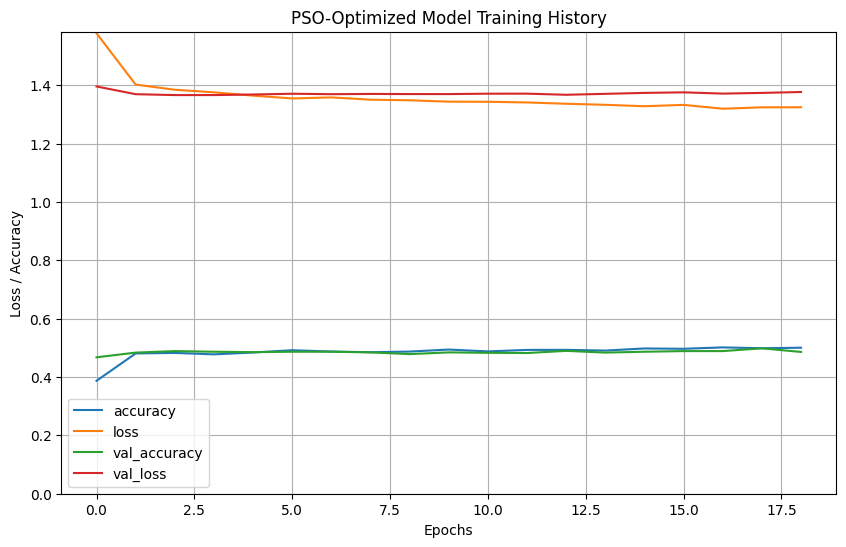


--- Evaluating PSO-Optimized Model on Test Set ---

PSO-Optimized Model Test Loss: 1.3780
PSO-Optimized Model Test Accuracy: 0.4894
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step

PSO-Optimized Model Classification Report:
              precision    recall  f1-score   support

        DARK       0.48      0.61      0.54       476
      DIVINE       0.00      0.00      0.00         1
       EARTH       0.45      0.73      0.55       380
        FIRE       0.82      0.15      0.25       154
       LIGHT       0.45      0.36      0.40       356
       WATER       0.85      0.46      0.59       175
        WIND       0.53      0.20      0.29       158

    accuracy                           0.49      1700
   macro avg       0.51      0.36      0.38      1700
weighted avg       0.54      0.49      0.47      1700

PSO-Optimized Matthews Correlation Coefficient (MCC): 0.3483
PSO-Optimized Cohen's Kappa: 0.3386
PSO-Optimized Balanced Accuracy: 0.3588

PSO-Optimized Model Confusion Matrix:


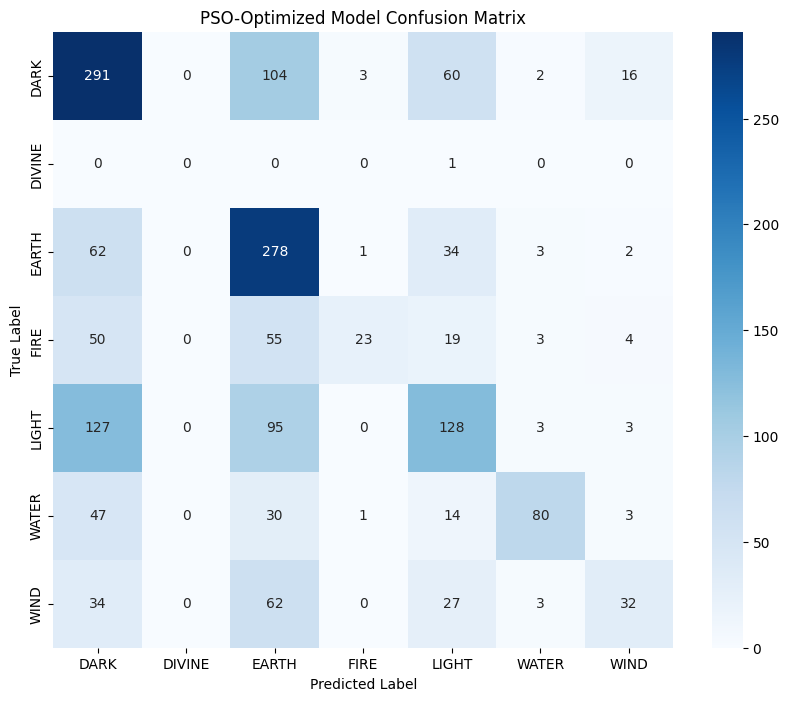

In [14]:
# Define the Final PSO-Optimized Model Architecture
print("\n--- Training Final Model with PSO-Optimized Hyperparameters ---")

# Use the formatted best hyperparameters from PSO

pso_optimized_model = Sequential([
    Input(shape=(input_dim,)),
    Dense(best_neurons_l1, activation='relu'),
    Dropout(best_dropout_l1),
    Dense(best_neurons_l2, activation='relu'),
    Dropout(best_dropout_l2),
    Dense(num_classes, activation='softmax')
])

# Compile the PSO-Optimized Model
print("\n--- Compiling PSO-Optimized Model ---")
pso_optimized_model.compile(
    optimizer=Adam(learning_rate=best_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

pso_optimized_model.summary()

# Train the PSO-Optimized Model
print("\n--- Training PSO-Optimized Model ---")
# Early stopping for the final optimized model
pso_final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Can be more patient for the final model
    restore_best_weights=True,
    verbose=1
)

# Train on the full X_train_full, y_train_full
history_final_pso = pso_optimized_model.fit(
    X_train_full, y_train_full,
    epochs=150,       # More epochs for the final model
    batch_size=best_batch_size,
    validation_split=0.2, # Use 20% of X_train_full for validation
    callbacks=[pso_final_early_stopping],
    verbose=1
)

# Plot Training History of PSO-Optimized Model
print("\n--- Plot PSO-Optimized Model Training History ---")
if history_final_pso.history:
    pd.DataFrame(history_final_pso.history).plot(figsize=(10, 6))
    plt.title("PSO-Optimized Model Training History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    min_loss_pso = min(history_final_pso.history.get('loss', [1]))
    max_acc_pso = max(history_final_pso.history.get('accuracy', [0]))
    plt.ylim(0, max(1.0, max_acc_pso * 1.2, min_loss_pso * 1.2))
    plt.grid(True)
    plt.show()
else:
    print("No training history to plot for PSO-optimized model.")

# Evaluate the PSO-Optimized Model on the Test Set
print("\n--- Evaluating PSO-Optimized Model on Test Set ---")
loss_pso_final, accuracy_pso_final = pso_optimized_model.evaluate(X_test, y_test, verbose=0)
print(f"\nPSO-Optimized Model Test Loss: {loss_pso_final:.4f}")
print(f"PSO-Optimized Model Test Accuracy: {accuracy_pso_final:.4f}")

# Get predictions
y_pred_probs_pso_final = pso_optimized_model.predict(X_test)
y_pred_pso_final = np.argmax(y_pred_probs_pso_final, axis=1)

# Classification Report
print("\nPSO-Optimized Model Classification Report:")
print(classification_report(y_test, y_pred_pso_final, target_names=target_class_names, zero_division=0))
pso_final_report_dict = classification_report(y_test, y_pred_pso_final, target_names=target_class_names, zero_division=0, output_dict=True)

# Additional Metrics
pso_final_mcc = matthews_corrcoef(y_test, y_pred_pso_final)
pso_final_cohen_kappa = cohen_kappa_score(y_test, y_pred_pso_final)
pso_final_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_pso_final)

print(f"PSO-Optimized Matthews Correlation Coefficient (MCC): {pso_final_mcc:.4f}")
print(f"PSO-Optimized Cohen's Kappa: {pso_final_cohen_kappa:.4f}")
print(f"PSO-Optimized Balanced Accuracy: {pso_final_balanced_accuracy:.4f}")

# Store other F1, precision, recall for final comparison
pso_final_macro_f1 = pso_final_report_dict['macro avg']['f1-score']
pso_final_weighted_f1 = pso_final_report_dict['weighted avg']['f1-score']
pso_final_macro_precision = pso_final_report_dict['macro avg']['precision']
pso_final_weighted_precision = pso_final_report_dict['weighted avg']['precision']
pso_final_macro_recall = pso_final_report_dict['macro avg']['recall']
pso_final_weighted_recall = pso_final_report_dict['weighted avg']['recall']

# Confusion Matrix
print("\nPSO-Optimized Model Confusion Matrix:")
cm_pso_final = confusion_matrix(y_test, y_pred_pso_final)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pso_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_class_names, yticklabels=target_class_names)
plt.title('PSO-Optimized Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
# Create a comparison DataFrame
comparison_data = {
    "Metric": [
        "Test Accuracy",
        "Test Loss",
        "Balanced Accuracy",
        "MCC",
        "Cohen's Kappa",
        "Macro Avg F1-score",
        "Weighted Avg F1-score",
        "Macro Avg Precision",
        "Weighted Avg Precision",
        "Macro Avg Recall",
        "Weighted Avg Recall"
    ],
    "Baseline Model": [
        accuracy_baseline,
        loss_baseline,
        baseline_balanced_accuracy,
        baseline_mcc,
        baseline_cohen_kappa,
        baseline_macro_f1,
        baseline_weighted_f1,
        baseline_macro_precision,
        baseline_weighted_precision,
        baseline_macro_recall,
        baseline_weighted_recall
    ],
    "PSO-Optimized Model": [
        accuracy_pso_final,
        loss_pso_final,
        pso_final_balanced_accuracy,
        pso_final_mcc,
        pso_final_cohen_kappa,
        pso_final_macro_f1,
        pso_final_weighted_f1,
        pso_final_macro_precision,
        pso_final_weighted_precision,
        pso_final_macro_recall,
        pso_final_weighted_recall
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Calculate the difference
comparison_df['Difference (PSO - Baseline)'] = comparison_df['PSO-Optimized Model'] - comparison_df['Baseline Model']

print("\n\n--- Comparison of Model Performance ---")
# Print with specific float formatting for better readability
print(comparison_df.to_string(index=False, float_format="%.4f"))


def highlight_diff(s):
     is_positive = s > 0
     is_negative = s < 0
     return ['color: green' if pos else 'color: red' if neg else '' for pos, neg in zip(is_positive, is_negative)]

comparison_df.style.apply(highlight_diff, subset=['Difference (PSO - Baseline)'])



--- Comparison of Model Performance ---
                Metric  Baseline Model  PSO-Optimized Model  Difference (PSO - Baseline)
         Test Accuracy          0.4924               0.4894                      -0.0029
             Test Loss          1.3700               1.3780                       0.0081
     Balanced Accuracy          0.3563               0.3588                       0.0025
                   MCC          0.3529               0.3483                      -0.0046
         Cohen's Kappa          0.3398               0.3386                      -0.0012
    Macro Avg F1-score          0.3716               0.3759                       0.0043
 Weighted Avg F1-score          0.4665               0.4690                       0.0025
   Macro Avg Precision          0.5327               0.5114                      -0.0213
Weighted Avg Precision          0.5549               0.5392                      -0.0157
      Macro Avg Recall          0.3563               0.3588         

,Metric,Baseline Model,PSO-Optimized Model,Difference (PSO - Baseline)
0,Test Accuracy,0.492353,0.489412,-0.002941
1,Test Loss,1.369994,1.378046,0.008052
2,Balanced Accuracy,0.356279,0.358786,0.002506
3,MCC,0.352935,0.348295,-0.004640
4,Cohen's Kappa,0.339801,0.338609,-0.001192
5,Macro Avg F1-score,0.371572,0.375850,0.004278
6,Weighted Avg F1-score,0.466513,0.469011,0.002497
7,Macro Avg Precision,0.532702,0.511415,-0.021287
8,Weighted Avg Precision,0.554942,0.539247,-0.015695
9,Macro Avg Recall,0.356279,0.358786,0.002506


# Analysis and Conclusion for The Yu-Gi-Oh Dataset

The results from this classification task provide a valuable case study on the performance of neural networks and PSO on a dataset with inherent complexities.

## 1. Baseline Performance vs. Random Chance

The baseline model achieved a test accuracy of approximately **49.24%**. While this figure may seem low, it is significantly better than the random guessing baseline for a 7-class problem (**1/7 ≈ 14.3%**). This demonstrates that the model was able to learn meaningful, albeit complex, patterns from the card features (`Level`, `ATK`, `DEF`, and `Primary_Type`) to predict the card's `Attribute`.

## 2. The Impact of Data Characteristics

The primary reason for the limited accuracy is the nature of the dataset itself:

- **Severe Class Imbalance**: The `"DIVINE"` attribute constitutes a tiny fraction of the dataset (only **5 instances total**). This makes it nearly impossible for the model to learn its characteristics, as reflected by its **zero F1-score**. This imbalance skews metrics like *Balanced Accuracy* and *Macro Avg F1-score* downwards, giving a more realistic picture of performance than raw accuracy alone.

- **Intrinsic Data Difficulty**: Unlike more structured scientific datasets (such as the NASA exoplanet data), the link between a Yu-Gi-Oh card's stats/type and its attribute may not always be strong or clear. Creative decisions in game design can lead to **high variance and less predictable correlations**, making this a challenging prediction task. The **data quality is high**, but the **predictive relationship is weak**.

## 3. Evaluating the PSO Optimization

The **Particle Swarm Optimization (PSO)** process ran for **600 evaluations** to find optimal hyperparameters. The key findings are:

- The PSO-optimized model showed a **marginal improvement in Balanced Accuracy** (from **0.3563** to **0.3588**), which was the metric it was designed to optimize on its internal validation set.
- However, this came at a **slight cost** to other metrics like overall accuracy and MCC.

This is a realistic outcome, demonstrating that for a **complex and imbalanced dataset**, even a thorough hyperparameter search may not yield dramatic improvements and can involve **trade-offs** between different performance metrics. The optimization found parameters that were optimal for a specific slice of the data, but they did not generalize to produce a uniformly better model on the final test set.

---

## Overall Conclusion

This experiment successfully demonstrates the application of **PSO for neural network evolution**. It highlights that while PSO can find better-performing hyperparameter configurations, its effectiveness is ultimately constrained by the **quality and predictive power of the underlying data**.

The contrast between the ~50% accuracy on this dataset and potentially higher accuracies on more balanced datasets showcases the **importance of data characteristics** in any machine learning project.
